## Import some helpful libraries

In [1]:
print("    Version control\n------------------------")
import os, fnmatch, random, math, sys, datetime
from pathlib import Path
import numpy as np;              print("Numpy\t\t", np.__version__)
import matplotlib as mpl;        print("matplotlib\t", mpl.__version__)
import matplotlib.pyplot as plt
import nibabel as nib;           print("NiBabel\t\t {}".format(nib.__version__))
from nibabel.testing import data_path
import pandas as pd;             print("Pandas\t\t {}".format(pd.__version__))
import imageio;                  print("imageio\t\t {}".format(imageio.__version__))
import h5py;                     print("H5py\t\t {}".format(h5py.__version__))
import sklearn;                  print("Scikit-learn\t {}".format(sklearn.__version__))
import skimage;                  print("Scikit-image\t {}".format(skimage.__version__))
import tensorflow as tf;         print("TensorFlow\t {}".format(tf.__version__))
import keras;                    print("Keras\t\t {}".format(keras.__version__))
import tensorflow.keras.backend as K
from tensorflow.keras import models, Input, Model
from tensorflow.keras.layers import Dense, Flatten, Reshape, BatchNormalization, Conv3D, MaxPooling3D, UpSampling3D, ZeroPadding3D
from tensorflow.keras.activations import relu, sigmoid
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.initializers import *
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras.engine.topology import Layer, InputSpec
from keras.optimizers import SGD
from tensorflow.keras.utils import plot_model
from IPython.display import Image
from sklearn.cluster import KMeans
# %load_ext tensorboard       
# %reload_ext tensorboard

    Version control
------------------------
Numpy		 1.19.4
matplotlib	 3.3.3
NiBabel		 3.2.0
Pandas		 1.1.4
imageio		 2.9.0
H5py		 2.10.0
Scikit-learn	 0.23.2
Scikit-image	 0.17.2
TensorFlow	 2.4.0
Keras		 2.4.3


## Dataset

In [2]:
## Load train data
data_source = "Data/data_random_1/" 
sample_train_subset = np.loadtxt(os.path.join(data_source, "sample_train.csv"), dtype=str, delimiter=",")
train_data = np.load(os.path.join(data_source, "train.npy")).reshape(100,182,218,182,1)
print('train_data shape is {}'.format(train_data.shape))

## Load validation data
sample_val_subset = np.loadtxt(os.path.join(data_source, "sample_valid.csv"), dtype=str, delimiter=",")
valid_data = np.load(os.path.join(data_source, "valid.npy")).reshape(24,182,218,182,1)
print('valid_data shape is {}'.format(valid_data.shape))

train_data shape is (100, 182, 218, 182, 1)
valid_data shape is (24, 182, 218, 182, 1)


In [3]:
# print("There are", len(sample_train_subset), " subset of train samples are:\n")
# print(*sample_train_subset, sep='\t')
# print("\n--------------------------------------------------------------------------------\n")
# print("There are", len(sample_val_subset), " subset of Validation samples are:\n")
# print(*sample_val_subset, sep='\t')

In [4]:
## Padding datasets
train_pad_data = (ZeroPadding3D(padding=(5,19,5))(train_data)).numpy()
print('train_padded_data shape is {}'.format(train_pad_data.shape))

valid_pad_data = (ZeroPadding3D(padding=(5,19,5))(valid_data)).numpy()
print('valid_padded_data shape is {}'.format(valid_pad_data.shape))

train_padded_data shape is (100, 192, 256, 192, 1)
valid_padded_data shape is (24, 192, 256, 192, 1)


In [5]:
## Showing slices

def show_slices(slices):
    fig, axes = plt.subplots(1, len(slices), figsize=(10,5))
    for i, slice in enumerate(slices):
        axes[i].imshow(slice.T, cmap="hot", origin="upper") # hot, Greys, gray

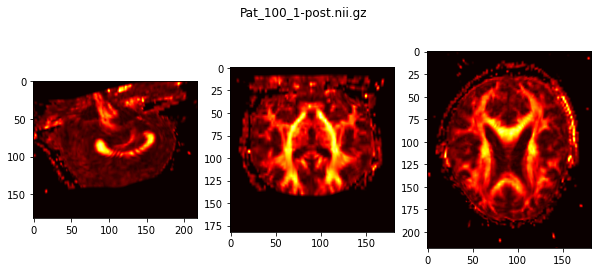

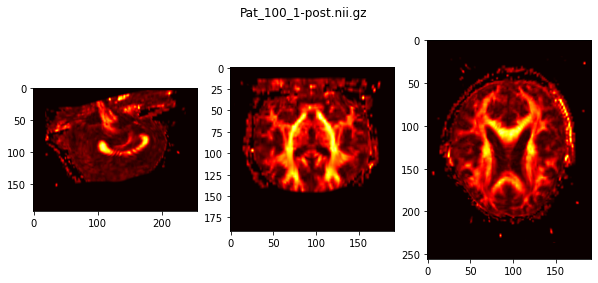

In [6]:
## Showing one or all Training samples in three dimension (one middle slice per each dimension)

for m in range(1):
    slice_0 = train_data[m, 91, :, :, 0]
    slice_1 = train_data[m, :, 109, :, 0]
    slice_2 = train_data[m, :, :, 91, 0]
    show_slices([slice_0, slice_1, slice_2])
    plt.suptitle(sample_train_subset[m], x=0.5, y=0.9)

for m in range(1):
    slice_3 = train_pad_data[m, 96, :, :, 0]
    slice_4 = train_pad_data[m, :, 128, :, 0]
    slice_5 = train_pad_data[m, :, :, 96, 0]
    show_slices([slice_3, slice_4, slice_5])
    plt.suptitle(sample_train_subset[m], x=0.5, y=0.9)

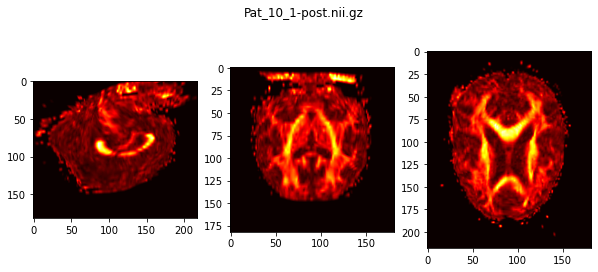

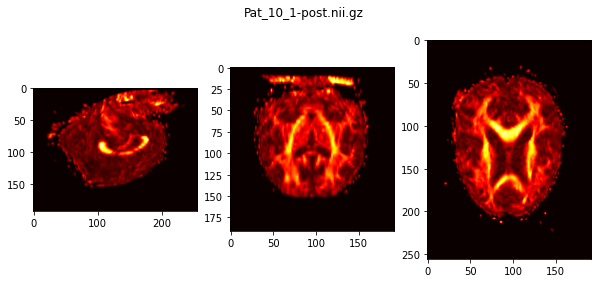

In [7]:
## Showing one or all Validation samples in three dimension (one middle slice per each dimension)

for m in range(1):
    slice_0 = valid_data[m, 91, :, :, 0]
    slice_1 = valid_data[m, :, 109, :, 0]
    slice_2 = valid_data[m, :, :, 91, 0]
    show_slices([slice_0, slice_1, slice_2])
    plt.suptitle(sample_val_subset[m], x=0.5, y=0.9)

for m in range(1):
    slice_3 = valid_pad_data[m, 96, :, :, 0]
    slice_4 = valid_pad_data[m, :, 128, :, 0]
    slice_5 = valid_pad_data[m, :, :, 96, 0]
    show_slices([slice_3, slice_4, slice_5])
    plt.suptitle(sample_val_subset[m], x=0.5, y=0.9)

## Model Design

In [8]:
## Convolutional AutoEncoder Model Designe:

IMAGE_HEIGHT = train_pad_data.shape[1]
IMAGE_WIDTH = train_pad_data.shape[2]
IMAGE_DEPTH = train_pad_data.shape[3]
BATCH_SIZE = 1
EPOCHS = 1
data_shape = [1, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_DEPTH, 1]
input_shape = [BATCH_SIZE, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_DEPTH, 1]
print("Padded data shape: {}\n".format(input_shape))

## Encoder
input_img = Input(shape=(192, 256, 192, 1), name='Input')
x = Conv3D(filters=128, kernel_size=3, strides=2, padding='same', activation='relu', name='Conv1')(input_img)
x = BatchNormalization(name='BN_Conv1')(x)
x = Conv3D(filters=64, kernel_size=3, strides=2, padding='same', activation='relu', name='Conv2')(x)
x = BatchNormalization(name='BN_Conv2')(x)
x = Conv3D(filters=32, kernel_size=3, strides=2, padding='same', activation='relu', name='Conv3')(x)
x = BatchNormalization(name='BN_Conv3')(x)
x = Conv3D(filters=16, kernel_size=3, strides=2, padding='same', activation='relu', name='Conv4')(x)
x = BatchNormalization(name='BN_Conv4')(x)
x = Conv3D(filters=8, kernel_size=3, strides=2, padding='same', activation='relu', name='Conv5')(x)
x = BatchNormalization(name='BN_Conv5')(x)

## Latent Features
shape_before_flattening = tf.keras.backend.int_shape(x)
x_LF = Flatten(name='LF')(x)

##____________________________________________________________________________________________________
# init = VarianceScaling(scale=1. / 3., mode='fan_in', distribution='uniform')
# encoded = Dense(50, kernel_initializer=init, activation='relu', name='encoded')(x_LF)
x_LF = Dense(100, activation='relu', name='encoded')(x_LF)
##____________________________________________________________________________________________________

encoded = x_LF    # Hadi for L200

##____________________________________________________________________________________________________
x = BatchNormalization(name='BN_Dense')(encoded)
# x = Dense(np.prod(shape_before_flattening[1:]), activation='relu', kernel_initializer=init)(encoded)
x = Dense(np.prod(shape_before_flattening[1:]), activation='relu')(x)
encoded = x
##____________________________________________________________________________________________________

x = Reshape(shape_before_flattening[1:], name='UnFlat')(encoded)

## Decoder
x = Conv3D(filters=8, kernel_size=3, padding='same', activation='relu', name='DeConv2')(x)
x = BatchNormalization(name='BN_DeConv2')(x)
x = UpSampling3D(size=(2, 2, 2), name='UpSampling2')(x)
x = Conv3D(filters=16, kernel_size=3, padding='same', activation='relu', name='DeConv3')(x)
x = BatchNormalization(name='BN_DeConv3')(x)
x = UpSampling3D(size=(2, 2, 2), name='UpSampling3')(x)
x = Conv3D(filters=32, kernel_size=3, padding='same', activation='relu', name='DeConv4')(x)
x = BatchNormalization(name='BN_DeConv4')(x)
x = UpSampling3D(size=(2, 2, 2), name='UpSampling4')(x)
x = Conv3D(filters=64, kernel_size=3, padding='same', activation='relu', name='DeConv5')(x)
x = BatchNormalization(name='BN_DeConv5')(x)
x = UpSampling3D(size=(2, 2, 2), name='UpSampling5')(x)
x = Conv3D(filters=128, kernel_size=3, padding='same', activation='relu', name='DeConv6')(x)
x = BatchNormalization(name='BN_DeConv6')(x)
x = UpSampling3D(size=(2, 2, 2), name='UpSampling6')(x)
decoded = Conv3D(filters=1, kernel_size=3, padding='same', activation='sigmoid', name='Output')(x)

model_CAE = Model(inputs=input_img, outputs=decoded, name='AutoEncoder')
## optimizer=rmsprop, sgd
model_CAE.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model_CAE.summary()
# plot_model(model_CAE, to_file='Convolutional_autoencoder_model.png', show_shapes=True)
# Image(filename='Convolutional_autoencoder_model.png')

Padded data shape: [1, 192, 256, 192, 1]

Model: "AutoEncoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 192, 256, 192, 1) 0         
_________________________________________________________________
Conv1 (Conv3D)               (None, 96, 128, 96, 128)  3584      
_________________________________________________________________
BN_Conv1 (BatchNormalization (None, 96, 128, 96, 128)  512       
_________________________________________________________________
Conv2 (Conv3D)               (None, 48, 64, 48, 64)    221248    
_________________________________________________________________
BN_Conv2 (BatchNormalization (None, 48, 64, 48, 64)    256       
_________________________________________________________________
Conv3 (Conv3D)               (None, 24, 32, 24, 32)    55328     
_________________________________________________________________
BN_Conv3 (Bat

## Model Training

In [10]:
## Start time:
from datetime import datetime
start_time = datetime.now().strftime("%Y_%m_%d___%H_%M"); print("\nStart Time =", start_time, "\n")

## Model Fit
model_CAE.load_weights(os.path.join("Weights/P5_100___2021_01_04___13_10.hdf5"), by_name=True)  # epochs 50

# model_checkpoint_callback = ModelCheckpoint(filepath=os.path.join("Check/L1___" + start_time), save_weights_only=True, save_best_only=True, monitor='val_loss', mode='max', verbose=1) 
# tb_callback = TensorBoard(os.path.join("Logs/L1___" + start_time), histogram_freq=1)
# early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=5, mode='auto')
# model_CAE.fit(train_data[0:10,:], train_data[0:10,:], validation_data=(valid_data, valid_data), epochs=EPOCHS, batch_size=BATCH_SIZE, shuffle=True, callbacks=[tb_callback, model_checkpoint_callback], verbose=1)
# model_CAE.fit(train_data, train_data, validation_data=(valid_data, valid_data), epochs=EPOCHS, batch_size=BATCH_SIZE, shuffle=True, callbacks=[tb_callback, model_checkpoint_callback], verbose=1)
# model_CAE.save_weights(os.path.join("Weights/L1___" + start_time + ".hdf5"))

## End time:
from datetime import datetime
end_time = datetime.now().strftime("%Y_%m_%d___%H_%M"); print("\nEnd Time =", end_time)


Start Time = 2021_01_04___21_09 


End Time = 2021_01_04___21_09


## Reconstruction

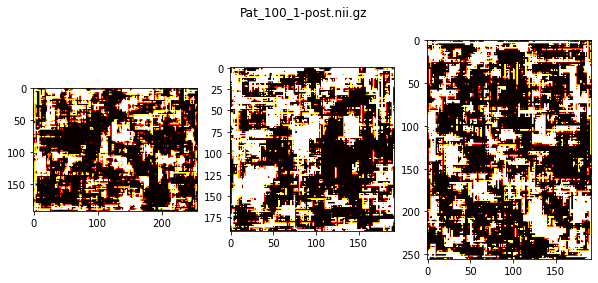

In [11]:
## Reconstructing data 

test_pad_data = train_pad_data[0,:].reshape(1, 192, 256, 192, 1)
reconstructed = model_CAE.predict(test_pad_data)

for m in range(1):
    slice_0 = reconstructed[m, 96, :, :, 0]
    slice_1 = reconstructed[m, :, 128, :, 0]
    slice_2 = reconstructed[m, :, :, 96, 0]
    show_slices([slice_0, slice_1, slice_2])
    plt.suptitle(sample_train_subset[m], x=0.5, y=0.9)

In [12]:
print('\ntrain_pad_data[0,100,100:105,100]\n\n {}'.format(train_pad_data[0,100,100:105,100]),'\n')
print('\nReconstructed_data[0,100,100:105,100]\n\n {}'.format(reconstructed[0,100,100:105,100]),'\n')


train_pad_data[0,100,100:105,100]

 [[0.16387394]
 [0.18857984]
 [0.20861967]
 [0.2608226 ]
 [0.3497885 ]] 


Reconstructed_data[0,100,100:105,100]

 [[0.]
 [0.]
 [0.]
 [0.]
 [0.]] 



## Weights

In [13]:
## Weights of Full-Model

h5_file = h5py.File(os.path.join("Weights/P5_100___2021_01_04___13_10.hdf5"), 'r')
print(h5_file)
Layer_size = len(list(h5_file.keys()))
Layer_names = list(h5_file.keys())
print("\nThere are", Layer_size, "layers in this model, named as:\n\n", Layer_names,'\n')
print('====================================================================\n')
for l in range(12, 13):  # Conv & Deconv (12, 23)
    layers = h5_file[Layer_names[l]]
    print("Layer", l+1, "-----", layers)
    W = layers[Layer_names[l]]['kernel:0']
    print('Layer', list(h5_file.keys())[l], '\tWeights\' shape: {}'.format(W.shape), '\n')
    print('\nWeights[0][0][0][0][0]: {}'.format(W[0][0][0][0][0:3]))    # Weights[1][1][1][0][1]
    print('====================================================================\n')
    Kernel_1 = W.shape[0]
    Kernel_2 = W.shape[1]
    Kernel_3 = W.shape[2]
    Kernel_all = np.zeros([Kernel_1, Kernel_2, Kernel_3])
    for f in range(W.shape[4]):   # W.shape[4]
        for x in range(Kernel_1):
            for y in range(Kernel_2):
                for z in range(Kernel_3):
                    Kernel_all[x][y][z] = W[x][y][z][0][f]
#         print('\nWeights of kernel', f+1, 'of', W.shape[4], ':\n\n', Kernel_all)

<HDF5 file "P5_100___2021_01_04___13_10.hdf5" (mode r)>

There are 32 layers in this model, named as:

 ['BN_Conv1', 'BN_Conv2', 'BN_Conv3', 'BN_Conv4', 'BN_Conv5', 'BN_DeConv2', 'BN_DeConv3', 'BN_DeConv4', 'BN_DeConv5', 'BN_DeConv6', 'BN_Dense', 'Conv1', 'Conv2', 'Conv3', 'Conv4', 'Conv5', 'DeConv2', 'DeConv3', 'DeConv4', 'DeConv5', 'DeConv6', 'Input', 'LF', 'Output', 'UnFlat', 'UpSampling2', 'UpSampling3', 'UpSampling4', 'UpSampling5', 'UpSampling6', 'dense', 'encoded'] 


Layer 13 ----- <HDF5 group "/Conv2" (1 members)>
Layer Conv2 	Weights' shape: (3, 3, 3, 128, 64) 


Weights[0][0][0][0][0]: [ 0.01714433 -0.01860613 -0.0200667 ]



## LF features

In [14]:
model_Encoder = Model(inputs=input_img, outputs=encoded, name='Encoder')
model_Encoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
# model_Encoder.summary()
# plot_model(model_Encoder, to_file='Encoder_model.png', show_shapes=True)
# Image(filename='Encoder_model.png')

In [15]:
test_pad_data = train_pad_data[0,:].reshape(1, 192, 256, 192, 1)
LF_features = model_Encoder.predict(test_pad_data)[0]

print('LF_features size: {} -------- {} \n'.format(LF_features.shape, type(LF_features)))
print('The first feature is {}\n'.format(LF_features[0]))
print(LF_features)

LF_features size: (2304,) -------- <class 'numpy.ndarray'> 

The first feature is 9.01965045928955

[ 9.01965    1.1902905  0.        ...  1.8525836 13.912475   0.       ]


(6, 8, 6, 8)


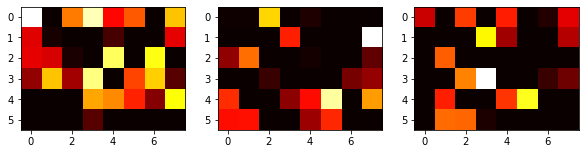

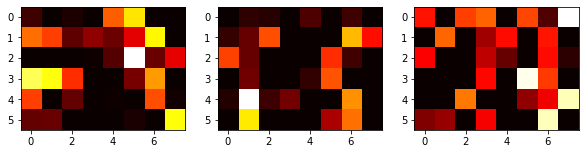

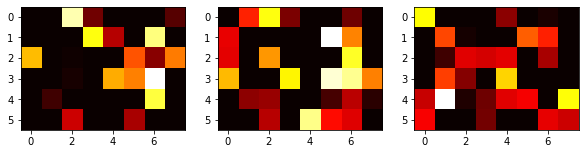

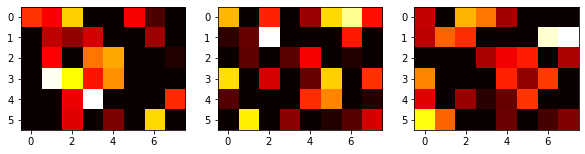

In [16]:
LLL = LF_features.reshape(6,8,6,8)
print(LLL.shape)   #(1, 192, 256, 192, 1)
for m in range(4):
    slice_0 = LLL[0, :, :, m]
    slice_1 = LLL[1, :, :, m]
    slice_2 = LLL[2, :, :, m]
    show_slices([slice_0, slice_1, slice_2])

In [ ]:
# tensorboard --logdir=Logs       ## http://localhost:6006/